# Taller 2 · Muestreo, señales discretas y aliasing

**Asignatura:** Teoría de la Información y Procesado de Señal
**Grado en Ciencia e Ingeniería de Datos (GCED) — Universidad de A Coruña**
**Duración:** 2 horas
**Modalidad:** Jupyter Notebook con asistencia de IA

---

## Objetivos de aprendizaje

Al finalizar este taller serás capaz de:

1. Comprender el **muestreo** como discretización de señales continuas.
2. Crear una función de **consulta temporal** que traduzca instantes de tiempo a muestras discretas.
3. Comprobar empíricamente que una sinusoide muestreada **puede perder su periodicidad**.
4. Demostrar que las **frecuencias de una señal discreta están acotadas**.
5. Distinguir entre **muestreo** y **diezmado**.
6. **Observar y escuchar el aliasing** cuando se viola el criterio de Nyquist.

---

## 🎯 Reto central del taller

> **¿Qué se pierde al pasar del mundo continuo al discreto?**
>
> Al muestrear, los índices $n$ pierden la referencia temporal, las sinusoides pueden dejar de ser periódicas, y las frecuencias se "pliegan". En este taller descubrirás estas consecuencias de forma práctica.

---

## Metodología de trabajo con IA

| Puedes pedir a la IA | NO debes pedir a la IA |
|---------------------|------------------------|
| Código de generación de señales | Que interprete los resultados por ti |
| Sintaxis de funciones NumPy | Que diseñe la función de consulta temporal |
| Ayuda con gráficas (stem, plot) | Que explique por qué se pierde la periodicidad |

> *La IA te ayuda a escribir código, pero no a entender señales. Eso es tu trabajo.*

---

## Identificación del estudiante

Completa los siguientes campos con tu información personal:

- **Apellidos:** López Bazarra

- **Nombre:** Juan

- **Email UDC:** juan.bazarra@udc.es

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from fractions import Fraction

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

print("✓ Entorno listo")

✓ Entorno listo


---

## Parte 1: Muestreo correcto — señal de referencia

### Contexto teórico

El **Teorema de Nyquist** establece que para reconstruir una señal sin ambigüedad:

$$F_s > 2 \cdot F_{\max}$$

donde $F_{\max}$ es la frecuencia más alta presente en la señal.

**Frecuencia de Nyquist:** $F_N = F_s / 2$

Al muestrear una señal continua $x(t)$ con periodo de muestreo $T_s = 1/F_s$:

$$x(t_n) = x(n \cdot T_s) \Rightarrow x[n]$$

**Importante:** $x[n]$ es una secuencia de números. El índice $n$ es un **entero**, no tiene unidades de tiempo.

---

### Bloque 1 · Generación de señal muestreada correctamente

#### 📝 Hipótesis previa

**Pregunta:** Con $F = 5$ Hz y $F_s = 50$ Hz, ¿cuántas muestras habrá por ciclo?

*Tu predicción:* `Habrá 10 muestras por ciclo, 50/5 = 10`

In [2]:


# === PARÁMETROS ===
F = 5       # Hz (frecuencia de la señal)
Fs = 50     # Hz (frecuencia de muestreo)
T = 1       # segundo
A = 1       # amplitud

# TODO: Calcula N y genera la secuencia de índices, n
N = int(Fs * T) # número de muestras
n = np.arange(N) # secuencia de índices 

# TODO: Genera la señal sinusoidal, x
t = n / Fs # vector de tiempo x = A * np.sin(2 * np.pi * F * t) # señal sinusoidal
x = A * np.sin(2 * np.pi * F * t)

In [3]:
# === VALIDACIÓN ===
assert x is not None, "Genera la señal"
assert len(x) == Fs * T, F"Esperado {Fs*T} muestras"

muestras_por_ciclo = Fs / F
ciclos_totales = F * T

print(f"✓ Señal generada: {len(x)} muestras")
print(f"  Muestras por ciclo: {muestras_por_ciclo}")
print(f"  Ciclos totales en {T}s: {ciclos_totales}")
print(f"  ¿Cumple Nyquist? Fs={Fs} > 2*F={2*F}: {Fs > 2*F}")

✓ Señal generada: 50 muestras
  Muestras por ciclo: 10.0
  Ciclos totales en 1s: 5
  ¿Cumple Nyquist? Fs=50 > 2*F=10: True


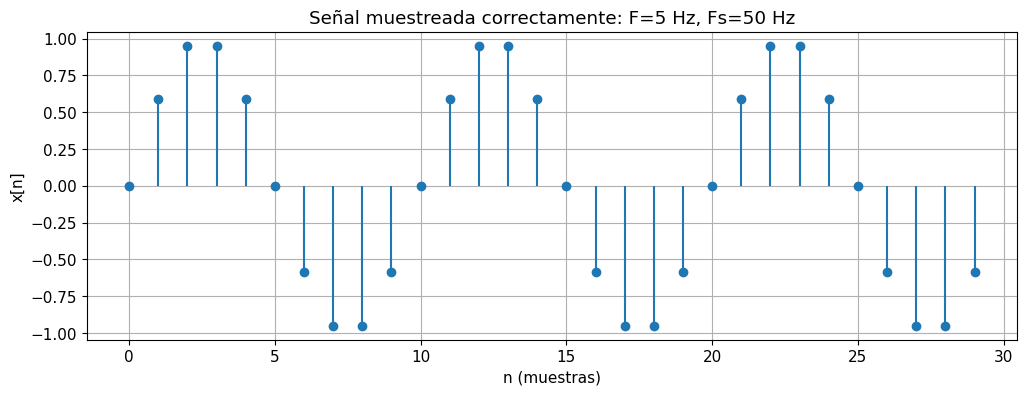

In [4]:
# === VISUALIZACIÓN ===
plt.figure(figsize=(12, 4))
plt.stem(n[:30], x[:30], basefmt=' ')
plt.title(f'Señal muestreada correctamente: F={F} Hz, Fs={Fs} Hz')
plt.xlabel('n (muestras)')
plt.ylabel('x[n]')
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿Cuántas muestras hay por cada ciclo? ¿Es suficiente para "ver" bien la forma de onda?**

*Tu respuesta:*

```
Hay 10 muestras por ciclo, tal y como se ve en la gráfica. Además es suficiente para ver la forma de la onda, debido a que el criterio de Nyquist se cumple (50 > 2*5).
```

**2. Observa que el eje X dice "n (muestras)", no "tiempo (s)". ¿Qué información necesitas para saber en qué instante de tiempo cae cada muestra?**

*Tu respuesta:*

```
Necesito conocer el periodo de muestreo $T_s$ para convertir el índice de muestra $n$ a tiempo. La relación es $t_n = n \cdot T_s$.
```

---

## Parte 2: Consulta temporal — acceso a señales discretas por tiempo

### Contexto

Imagina que recibes una señal digital de un sensor de temperatura:

$$x[n] = [19.60, \; 19.68, \; 19.74, \; 19.83, \; 19.91, \; 20.01]$$

Te preguntan: **¿cuál es la temperatura en el segundo 0.75?**

Para responder, necesitas saber:
- **¿Cada cuánto tiempo se toman las muestras?** → Periodo de muestreo $T_s$ (o frecuencia $F_s$)
- **¿Cuándo se tomó la primera muestra?** → Instante inicial $t_{inicio}$

Sin estos dos datos, $x[n]$ es solo una lista de números sin referencia temporal.

**Ejemplo de la diapositiva de teoría:**
- $T_s = 0.5$ s ($F_s = 2$ Hz), $t_{inicio} = -1$ s
- La primera muestra ($n=0$ en Python) corresponde a $t = -1$ s
- Cada muestra posterior corresponde a un instante $0.5$ s más tarde

---

### Bloque 2A · Analizar qué necesita la función

#### 📝 Hipótesis previa

**Pregunta:** Si tienes `x = [19.60, 19.68, 19.74, 19.83, 19.91, 20.01]`, $F_s = 2$ Hz y $t_{inicio} = -1$ s:

- ¿A qué instante corresponde `x[0]`? 19.60
- ¿A qué instante corresponde `x[3]`? 19.83
- ¿Qué valor tiene la señal en $t = 0$ s? 19.74
- ¿Qué valor tiene la señal en $t = 0.75$ s? 

In [5]:
# === EJEMPLO: sensor de temperatura ===
x_temp = np.array([19.60, 19.68, 19.74, 19.83, 19.91, 20.01])
Fs_temp = 2       # Hz (una muestra cada 0.5 s)
t_inicio = -1.0   # la primera muestra se tomó en t = -1 s

# Calcula el vector de tiempos correspondiente a cada muestra
Ts_temp = 1 / Fs_temp
t_temp = t_inicio + np.arange(len(x_temp)) * Ts_temp

print("Muestras y sus instantes de tiempo:")
print("-" * 40)
for i, (ti, xi) in enumerate(zip(t_temp, x_temp)):
    print(f"  x[{i}] → t = {ti:+.1f} s → {xi:.2f}°")
print(f"\nPregunta: ¿Qué temperatura hay en t = 0 s?")
print(f"  n = (t - t_inicio) / Ts = (0 - ({t_inicio})) / {Ts_temp} = {(0 - t_inicio) / Ts_temp}")
print(f"  ¡Es un entero! Hay muestra exacta en t = 0 s")
print(f"\nPregunta: ¿Qué temperatura hay en t = 0.75 s?")
print(f"  n = (t - t_inicio) / Ts = (0.75 - ({t_inicio})) / {Ts_temp} = {(0.75 - t_inicio) / Ts_temp}")
print(f"  ¡No es un entero! No hay muestra exacta en t = 0.75 s")

Muestras y sus instantes de tiempo:
----------------------------------------
  x[0] → t = -1.0 s → 19.60°
  x[1] → t = -0.5 s → 19.68°
  x[2] → t = +0.0 s → 19.74°
  x[3] → t = +0.5 s → 19.83°
  x[4] → t = +1.0 s → 19.91°
  x[5] → t = +1.5 s → 20.01°

Pregunta: ¿Qué temperatura hay en t = 0 s?
  n = (t - t_inicio) / Ts = (0 - (-1.0)) / 0.5 = 2.0
  ¡Es un entero! Hay muestra exacta en t = 0 s

Pregunta: ¿Qué temperatura hay en t = 0.75 s?
  n = (t - t_inicio) / Ts = (0.75 - (-1.0)) / 0.5 = 3.5
  ¡No es un entero! No hay muestra exacta en t = 0.75 s


---

### Bloque 2B · Implementar la función de consulta temporal

Crea una función `consultar_valor(x, t, Fs, t_inicio)` que:

1. Calcule el índice $n$ correspondiente al instante $t$
2. Si $n$ corresponde a una muestra exacta: devuelva ese valor y una indicación que ese valor existe (True)
3. Si $n$ NO es entero: devuelva la **media** de la muestra anterior y la siguiente, e indique que ese valor no existe (False), y, por lo tanto, lo devuelto es una **aproximación por interpolación**.

La función debe devolver una tupla `(valor, es_exacto)` donde:
- `valor` es el valor de la señal (exacto o interpolado)
- `es_exacto` es `True` si la muestra existía, `False` si fue interpolada

In [6]:
# === IMPLEMENTACIÓN ===
def consultar_valor(x, t, Fs, t_inicio):
    """
    Consulta el valor de una señal discreta en un instante de tiempo.

    Parámetros:
        x        : np.array, señal discreta
        t        : float, instante de tiempo a consultar (en segundos)
        Fs       : float, frecuencia de muestreo (Hz)
        t_inicio : float, instante temporal de la primera muestra (s)

    Retorna:
        (valor, es_exacto) : tupla con el valor y un booleano indicando si es exacto o interpolado
    """
    Ts = 1 / Fs

    # Índice (real, no necesariamente entero)
    n_real = (t - t_inicio) / Ts

    # ¿Corresponde exactamente a una muestra?
    es_exacto = float(n_real).is_integer()

    if es_exacto:
        n_entero = int(round(n_real))
        if n_entero < 0 or n_entero >= len(x):
            raise IndexError("Instante fuera del rango de la señal")
        return x[n_entero], True
    else:
        n0 = int(np.floor(n_real))
        n1 = int(np.ceil(n_real))
        if n0 < 0 or n1 >= len(x):
            raise IndexError("Instante fuera del rango de la señal para interpolación")
        valor = (x[n0] + x[n1]) / 2
        return valor, False

In [7]:
# === VALIDACIÓN ===
# Test 1: consulta en instante exacto
val, exacto = consultar_valor(x_temp, 0.5, Fs_temp, t_inicio)
assert exacto == True, "t=0.5s debería corresponder a una muestra exacta"
assert np.isclose(val, 19.83), f"Valor incorrecto en t=0.5s: {val}"
print(f"✓ t=0.5s → x = {val:.2f}° ({'exacto' if exacto else 'interpolado'})")

# Test 2: consulta en instante no existente
val, exacto = consultar_valor(x_temp, 0.75, Fs_temp, t_inicio)
assert exacto == False, "t=0.75s NO corresponde a una muestra exacta"
esperado = (19.83 + 19.91) / 2  # media entre muestras adyacentes
assert np.isclose(val, esperado), f"Interpolación incorrecta: {val} != {esperado}"
print(f"✓ t=0.75s → x ≈ {val:.2f}° ({'exacto' if exacto else 'interpolado'})")

# Test 3: primera y última muestra
val, exacto = consultar_valor(x_temp, -1.0, Fs_temp, t_inicio)
assert exacto and np.isclose(val, 19.60)
print(f"✓ t=-1.0s → x = {val:.2f}° ({'exacto' if exacto else 'interpolado'})")

val, exacto = consultar_valor(x_temp, 1.5, Fs_temp, t_inicio)
assert exacto and np.isclose(val, 20.01)
print(f"✓ t=1.5s → x = {val:.2f}° ({'exacto' if exacto else 'interpolado'})")

print("\n✓ Todos los tests pasados")

✓ t=0.5s → x = 19.83° (exacto)
✓ t=0.75s → x ≈ 19.87° (interpolado)
✓ t=-1.0s → x = 19.60° (exacto)
✓ t=1.5s → x = 20.01° (exacto)

✓ Todos los tests pasados


In [8]:
# === DEMOSTRACIÓN CON LA SEÑAL DE LA PARTE 1 ===
# Usamos la señal sinusoidal de la Parte 1
t_inicio_senal = 0.0  # comenzamos en t=0

# Consultas en instantes exactos e interpolados
instantes_consulta = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]

print(f"Señal: f={F} Hz, Fs={Fs} Hz, t_inicio={t_inicio_senal} s")
print("-" * 60)
for t_q in instantes_consulta:
    val, exacto = consultar_valor(x, t_q, Fs, t_inicio_senal)
    tipo = "EXACTO" if exacto else "INTERPOLADO"
    print(f"  t = {t_q:.3f} s → x ≈ {val:.4f}  [{tipo}]")

Señal: f=5 Hz, Fs=50 Hz, t_inicio=0.0 s
------------------------------------------------------------
  t = 0.000 s → x ≈ 0.0000  [EXACTO]
  t = 0.010 s → x ≈ 0.2939  [INTERPOLADO]
  t = 0.025 s → x ≈ 0.7694  [INTERPOLADO]
  t = 0.050 s → x ≈ 0.9511  [INTERPOLADO]
  t = 0.075 s → x ≈ 0.7694  [INTERPOLADO]
  t = 0.100 s → x ≈ 0.0000  [EXACTO]


### ✍️ Explicación (OBLIGATORIA)

**1. ¿Por qué la función necesita recibir $F_s$ y $t_{inicio}$ además de la señal y el tiempo? ¿Qué pasaría si no los tuvieras?**

*Tu respuesta:*

```
La función necesita el parámetro F_s para poder calcular el peridodo de muestreo T_s, para así saber cada cuanto tiempo se toman las muestras. El parámetro t_inicio es necesario para saber que valor toma la muestra en n=0, es decir, el instante de tiempo que corresponde a la primera muestra. Sin estos dos parámetros, no podríamos relacionar los índices de las muestras con instantes de tiempo específicos, y por lo tanto no podríamos responder a la pregunta de cuál es el valor de la señal en un instante dado.
```

**2. ¿Es la interpolación lineal (media de muestras adyacentes) una buena aproximación? ¿Cuándo podría fallar?**

*Tu respuesta:*

```
Es muy buena aproximación para señales que cambian de forma suave entre muestras, pero podría fallar si la señal tiene cambios bruscos. Podriafallar también si la señal tiene componentes de alta frecuencia, ya que en ese caso la señal podría cambiar significativamente entre muestras, y la interpolación lineal no capturaría esos cambios.
```

**3. Si dos sensores muestrean la misma magnitud pero con diferente $F_s$ y $t_{inicio}$, ¿pueden producir la misma secuencia $x[n]$?**

*Tu respuesta:*

```
Sí, es posible que dos sensores produzcan la misma secuencia x[n] si sus parámetros de muestreo (F_s y t_inicio) están relacionados de tal manera que las muestras caen en los mismos instantes de tiempo. Por ejemplo, si un sensor tiene F_s = 2 Hz y t_inicio = -1 s, y otro sensor tiene F_s = 4 Hz y t_inicio = -0.5 s, ambos podrían muestrear la misma señal en los mismos instantes de tiempo, produciendo la misma secuencia x[n].
```

**4. Si se pide el valor en un instante anterior a la primera muestra, o posterior a la última. ¿Cómo lo resolverías?**

*Tu respuesta:*

```
Lo que haría sería extrapolar el valor utilizando las muestras disponibles. Para un instante anterior a la primera muestra, podría usar la primera muestra y la segunda para extrapolar hacia atrás. Para un instante posterior a la última muestra, podría usar la última muestra y la penúltima para extrapolar hacia adelante. Sin embargo, esta extrapolación puede ser menos precisa que la interpolación, especialmente si la señal cambia rápidamente.
```

---

## Parte 3: Periodicidad de señales muestreadas

### Contexto teórico

Una señal continua $x(t) = \cos(2\pi F_0 t)$ es **siempre periódica** con periodo $T_0 = 1/F_0$.

Pero al muestrearla obtenemos $x[n] = \cos(2\pi f_0 n)$, donde $f_0 = F_0/F_s$ es la **frecuencia normalizada** (en ciclos/muestra).

La señal discreta es periódica ($x[n+N] = x[n]$ para todo $n$) **si y solo si** existe un entero $N$ tal que:

$$2\pi f_0 N = 2\pi k \quad \Rightarrow \quad f_0 = \frac{k}{N}, \quad k, N \in \mathbb{Z}$$

Es decir, **$f_0$ debe ser un número racional**.

Si $f_0$ es irracional (por ejemplo $f_0 = 1/\sqrt{2}$), la señal discreta **nunca se repite exactamente**.

---

### Bloque 3 · Caso periódico vs no periódico

#### 📝 Hipótesis previa

**Pregunta:** Sea $F_0 = 5$ Hz y $F_s = 40$ Hz. La frecuencia normalizada es $f_0 = 5/40 = 1/8$.

- ¿Es $f_0 = 1/8$ un número racional? No, es un número decimal.
- ¿Cuál sería el periodo fundamental $N$? El periodo será 8muestras, ya que $f_0 = 1/8$ implica que la señal se repite cada 8 muestras. 
- Si ahora $f_0 = 1/\sqrt{6} \approx 0.4082$, ¿será periódica? No, porque $1/\sqrt{6}$ es un número irracional, lo que significa que la señal discreta no se repetirá exactamente en ningún punto, y por lo tanto no será periódica.

In [9]:
# === CASO 1: Frecuencia racional → periódica ===
f0_racional = Fraction(1, 8)  # f0 = 1/8 (racional)
N_periodo = f0_racional.denominator  # periodo fundamental
k = f0_racional.numerator

print(f"=== CASO 1: f0 = {f0_racional} (racional) ===")
print(f"  Periodo fundamental N = {N_periodo}")
print(f"  Número de ciclos por periodo k = {k}")

# Generamos señal con suficientes muestras para ver varios periodos
n_test = np.arange(40)
x_periodica = np.cos(2 * np.pi * float(f0_racional) * n_test)

# TODO: Completa la verificación empírica de que x[n] == x[n+N] para las primeras N muestras, mostrando los valores de x[n] y x[n+N], y la diferencia entre ellos
# Formato de salida sugerido:  x[1] = 0.aaaa,  x[9] = 0.bbb,  diferencia = 0.cccc
print(f"\nComprobación: ¿x[n] == x[n + {N_periodo}]?")
for i in range(N_periodo):
    xn = x_periodica[i]
    xnN = x_periodica[i + N_periodo]
    diff = abs(xn - xnN)
    print(f"  x[{i}] = {xn:.4f},  x[{i+N_periodo}] = {xnN:.4f},  diferencia = {diff:.4e}")

    

=== CASO 1: f0 = 1/8 (racional) ===
  Periodo fundamental N = 8
  Número de ciclos por periodo k = 1

Comprobación: ¿x[n] == x[n + 8]?
  x[0] = 1.0000,  x[8] = 1.0000,  diferencia = 0.0000e+00
  x[1] = 0.7071,  x[9] = 0.7071,  diferencia = 1.1102e-16
  x[2] = 0.0000,  x[10] = 0.0000,  diferencia = 2.4493e-16
  x[3] = -0.7071,  x[11] = -0.7071,  diferencia = 7.7716e-16
  x[4] = -1.0000,  x[12] = -1.0000,  diferencia = 0.0000e+00
  x[5] = -0.7071,  x[13] = -0.7071,  diferencia = 5.5511e-16
  x[6] = -0.0000,  x[14] = -0.0000,  diferencia = 2.4493e-16
  x[7] = 0.7071,  x[15] = 0.7071,  diferencia = 7.7716e-16


In [10]:
# === CASO 2: Frecuencia irracional → NO periódica ===
f0_irracional = 1 / np.sqrt(70)

print(f"=== CASO 2: f0 = 1/√70 ≈ 1/{np.sqrt(70):.5f} ≈ {f0_irracional:.5f} (irracional) => El periodo sería {1/f0_irracional:.5f} y NO es entero ===")
N_aprox = int(np.round(1 / f0_irracional))
print(f"  Aproximación para considerar N entero: N_aprox = {N_aprox}")
print(f"  Número de ciclos por periodo k = {k}")

# Generamos señal con suficientes muestras para ver varios periodos
n_test2 = np.arange(40)
x_no_periodica = np.cos(2 * np.pi * float(f0_irracional) * n_test)

# TODO: Completa la verificación empírica de que x[n] == x[n+N] para las primeras N muestras, mostrando los valores de x[n] y x[n+N], y la diferencia entre ellos
# Formato de salida sugerido:  x[1] = 0.aaaa,  x[9] = 0.bbb,  diferencia = 0.cccc
print(f"\nComprobación: ¿x[n] == x[n + {N_aprox}]?")
for i in range(N_aprox):
    xn = x_no_periodica[i] 
    xnN = x_no_periodica[i + N_aprox] 
    diff = abs(xn - xnN) 
    print(f" x[{i}] = {xn:.4f}, x[{i+N_aprox}] = {xnN:.4f}, diferencia = {diff:.4e}")

    

=== CASO 2: f0 = 1/√70 ≈ 1/8.36660 ≈ 0.11952 (irracional) => El periodo sería 8.36660 y NO es entero ===
  Aproximación para considerar N entero: N_aprox = 8
  Número de ciclos por periodo k = 1

Comprobación: ¿x[n] == x[n + 8]?
 x[0] = 1.0000, x[8] = 0.9623, diferencia = 3.7659e-02
 x[1] = 0.7310, x[9] = 0.8890, diferencia = 1.5797e-01
 x[2] = 0.0688, x[10] = 0.3374, diferencia = 2.6861e-01
 x[3] = -0.6305, x[11] = -0.3957, diferencia = 2.3475e-01
 x[4] = -0.9905, x[12] = -0.9159, diferencia = 7.4606e-02
 x[5] = -0.8177, x[13] = -0.9434, diferencia = 1.2568e-01
 x[6] = -0.2050, x[14] = -0.4634, diferencia = 2.5835e-01
 x[7] = 0.5180, x[15] = 0.2660, diferencia = 2.5204e-01


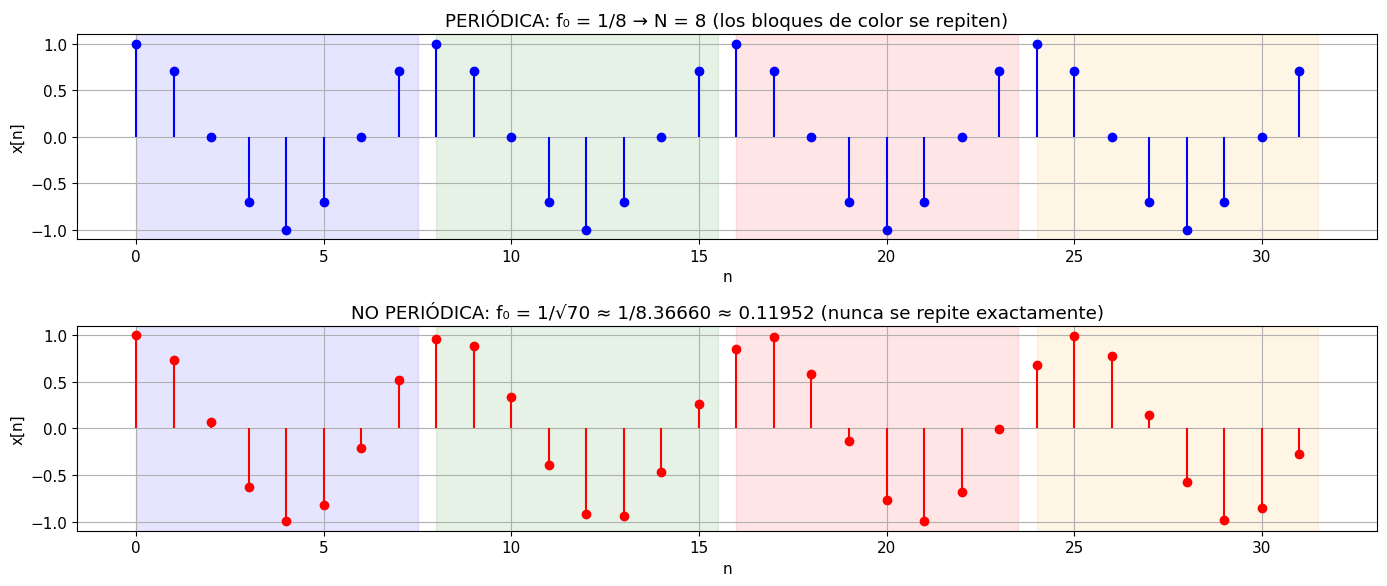

In [11]:
# === VISUALIZACIÓN COMPARATIVA ===
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Caso periódico
axes[0].stem(n_test[:32], x_periodica[:32], basefmt=' ', markerfmt='bo', linefmt='b-')
# Marcar los periodos
for p in range(4):
    axes[0].axvspan(p*N_periodo, (p+1)*N_periodo - 0.5, alpha=0.1, color=['blue','green','red','orange'][p])
axes[0].set_title(f'PERIÓDICA: f₀ = {f0_racional} → N = {N_periodo} (los bloques de color se repiten)')
axes[0].set_xlabel('n')
axes[0].set_ylabel('x[n]')

# Caso no periódico
axes[1].stem(n_test2[:32], x_no_periodica[:32], basefmt=' ', markerfmt='ro', linefmt='r-')
# Marcar los periodos
for p in range(4):
    axes[1].axvspan(p*N_periodo, (p+1)*N_periodo - 0.5, alpha=0.1, color=['blue','green','red','orange'][p])
axes[1].set_title(f'NO PERIÓDICA: f₀ = 1/√70 ≈ 1/{np.sqrt(70):.5f} ≈ {f0_irracional:.5f} (nunca se repite exactamente)')
axes[1].set_xlabel('n')
axes[1].set_ylabel('x[n]')

plt.tight_layout()
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿Por qué una señal continua periódica puede dejar de ser periódica al muestrearla?**

*Tu respuesta:*

```
Una señal continua periódica puede dejar de ser periódica si al muestrearla se obtiene una frecuencia irracional en términos de ciclos por muestra. Esto ocurre cuando la frecuencia normalizada $f_0 = F_0 / F_s$ no es un número racional.
```

**2. ¿Qué condición debe cumplir la relación $F_0 / F_s$ para que la señal discreta sea periódica?**

*Tu respuesta:*

```
La relación $F_0 / F_s$ debe ser un número racional, es decir, debe poder expresarse como una fracción de dos enteros $k/N$. Esto garantiza que la señal discreta se repetirá cada N muestras.
```

---

## Parte 4: Frecuencias acotadas en señales discretas

### Contexto teórico

En señales continuas, la frecuencia puede crecer sin límite: $\cos(2\pi F_0 t)$ con $F_0 \to \infty$ oscila cada vez más rápido.

En señales discretas, esto **NO** es así. Observa:

$$\cos(2\pi f_0 n) = \cos\big((2\pi f_0 + 2\pi)n\big) = \cos(2\pi(f_0 + 1) \cdot n)$$

Esto es porque $n$ es entero, y sumar $2\pi n$ al argumento de un coseno no cambia nada (son vueltas completas a la circunferencia).

**Consecuencia:** Las frecuencias $f_0$ y $f_0 + 1$ producen **exactamente la misma señal discreta**.

Por tanto, todas las frecuencias distintas de una señal discreta están en el rango:

$$-\frac{1}{2} \leq f_0 < \frac{1}{2}$$

La frecuencia $f_0 = 0.5$ (media muestra por ciclo) es la **máxima frecuencia representable**, y corresponde a la alternancia $+1, -1, +1, -1, \ldots$

---

### Bloque 4A · Señales con frecuencia creciente

#### 📝 Hipótesis previa

**Pregunta:** Si generas $\cos(2\pi f_0 n)$ para $f_0 = 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9$:

- ¿Cuáles crees que "oscilarán cada vez más rápido"? 0.1, 0.2, 0.3, 0.4 oscilarán cada vez más rápido, pero a partir de 0.5 la frecuencia dejará de aumentar y comenzará a "oscilar más lento" debido al aliasing.
- ¿Qué pasará cuando $f_0 > 0.5$? Cuando $f_0 > 0.5$, la señal comenzará a "oscilar más lento" debido al aliasing, ya que las frecuencias mayores a 0.5 se pliegan de vuelta al rango de -0.5 a 0.5. 


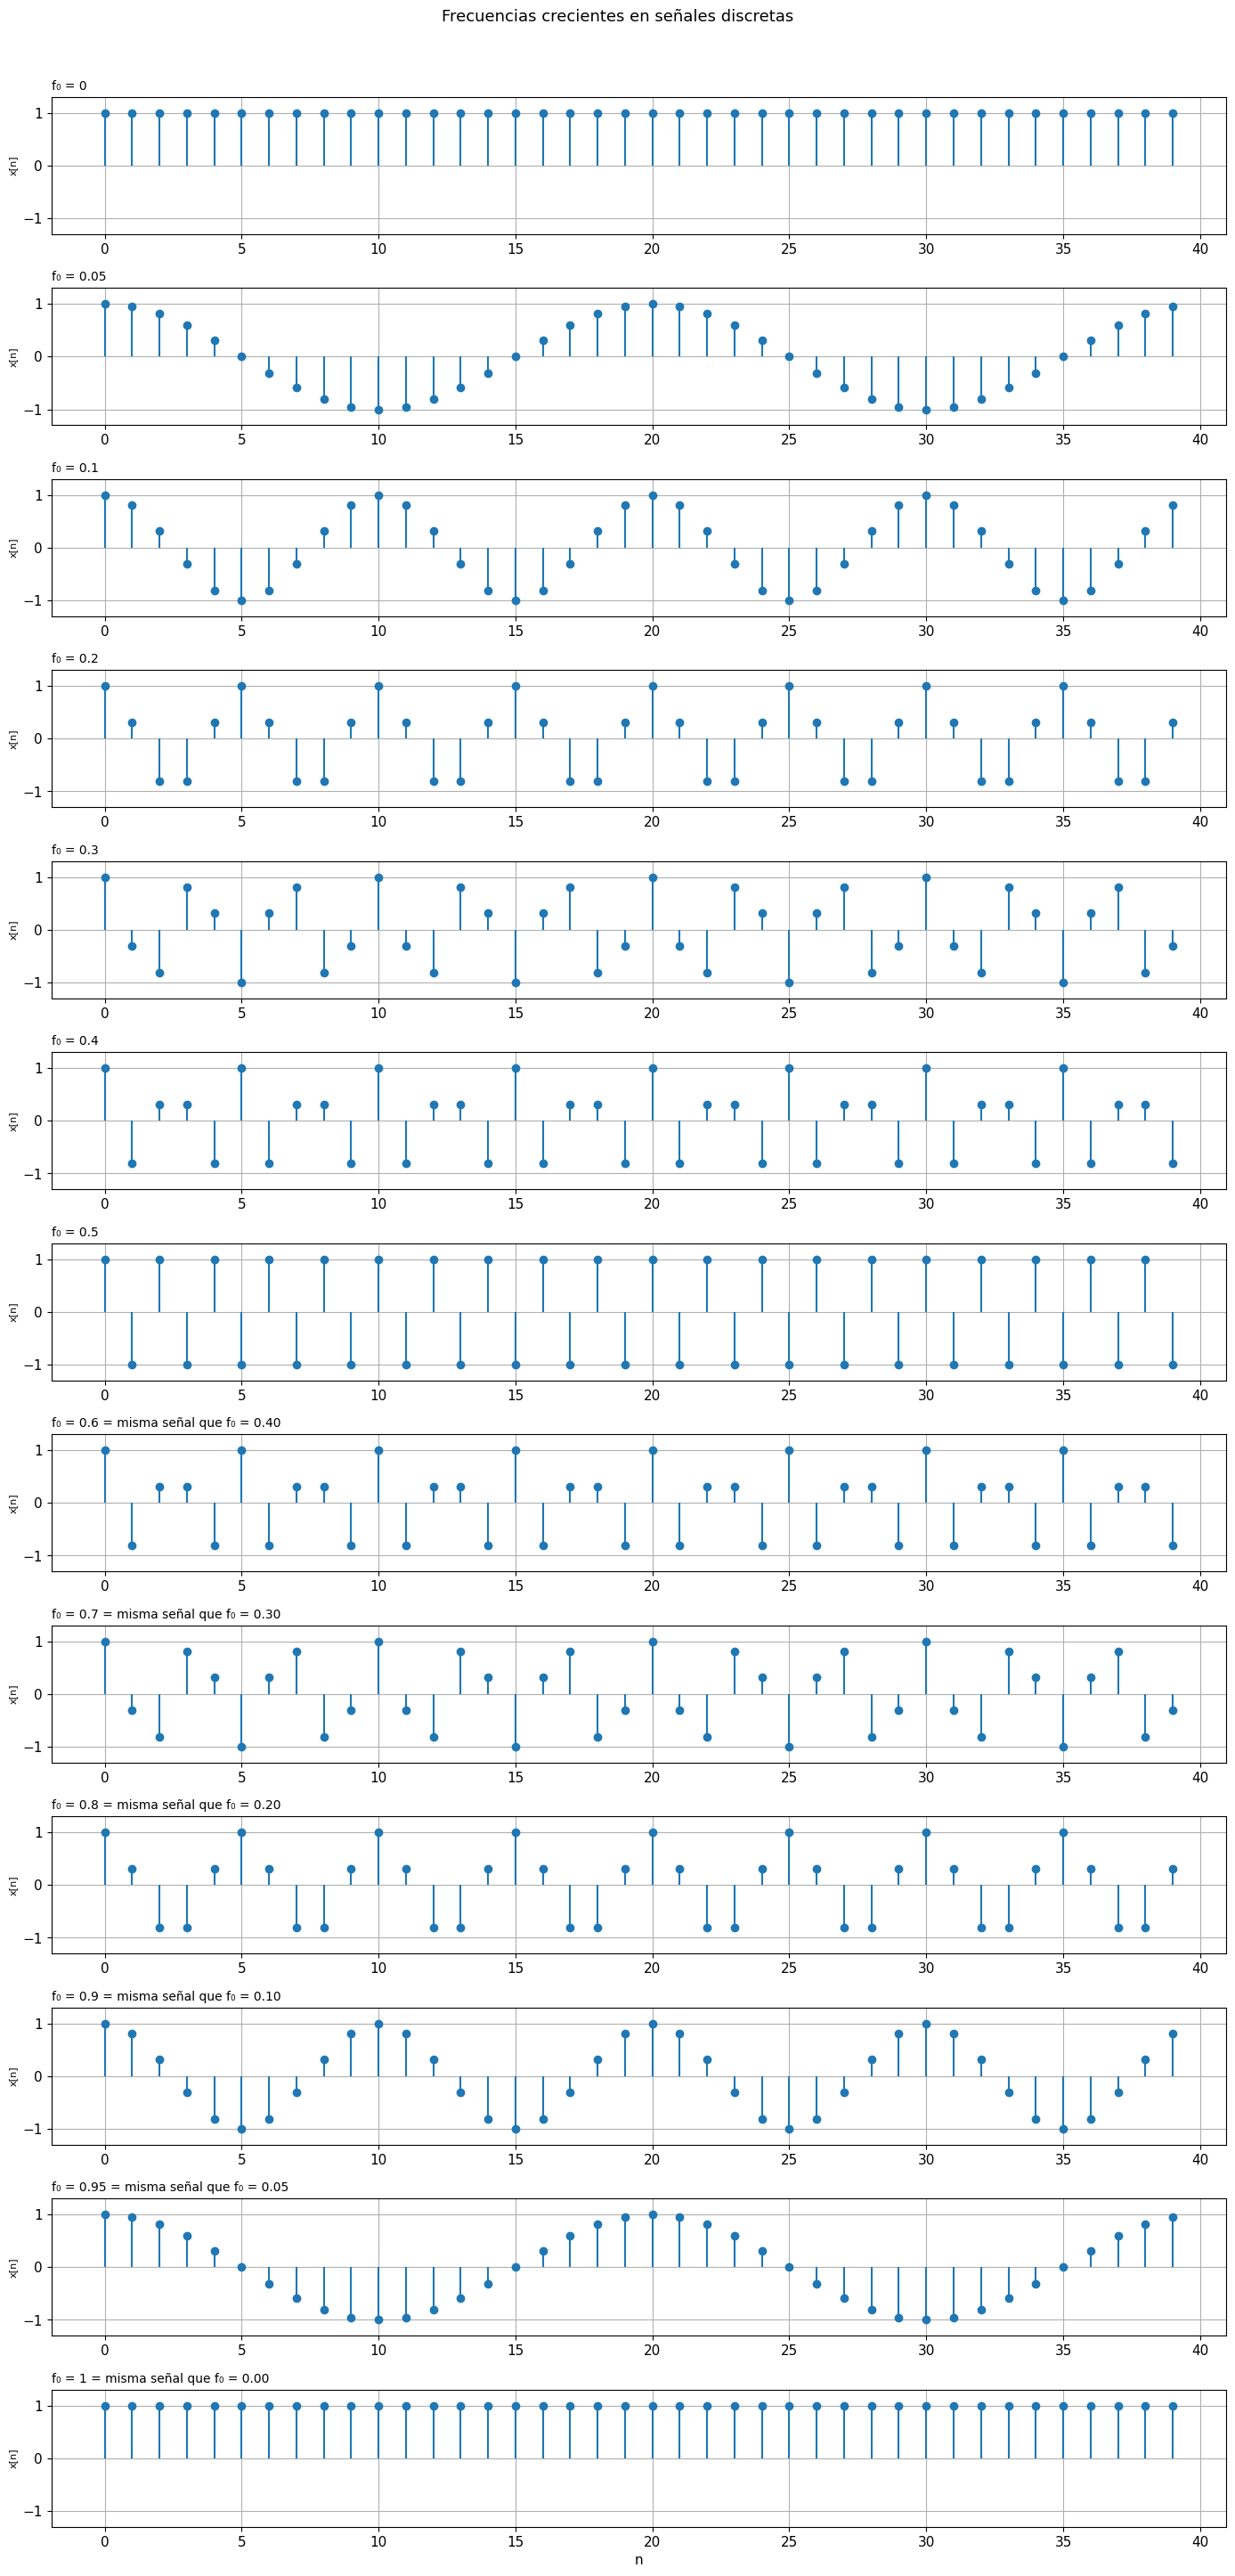

In [12]:
# === IMPLEMENTACIÓN ===
frecuencias_f0 = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
n_demo = np.arange(40)

fig, axes = plt.subplots(len(frecuencias_f0), 1, figsize=(14, 2.2*len(frecuencias_f0)))

for i, f0 in enumerate(frecuencias_f0):
    x_f0 = np.cos(2 * np.pi * f0 * n_demo)
    axes[i].stem(n_demo, x_f0, basefmt=' ', markerfmt='o', linefmt='-')

    # Indica la frecuencia "equivalente" en [-0.5, 0.5)
    f0_equiv = f0 - round(f0)  # reduce a [-0.5, 0.5)
    if abs(f0_equiv) < 1e-10:
        f0_equiv = 0.0
    nota = ""
    if abs(f0 - abs(f0_equiv)) > 0.001:
        nota = f" = misma señal que f₀ = {abs(f0_equiv):.2f}"

    axes[i].set_title(f'f₀ = {f0}{nota}', fontsize=10, loc='left')
    axes[i].set_ylabel('x[n]', fontsize=8)
    axes[i].set_ylim([-1.3, 1.3])

axes[-1].set_xlabel('n')
plt.suptitle('Frecuencias crecientes en señales discretas', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

In [13]:
# === COMPROBACIÓN NUMÉRICA ===
# Verificar que f0 y f0+1 producen la misma señal
n_check = np.arange(20)

pares_equivalentes = [(0, 1), (0.1, 1.1), (0.2, 1.2), (0.3, 0.7), (0.1, 0.9)]

print("Verificación: ¿cos(2π·f_a·n) == cos(2π·f_b·n)?")
print("=" * 50)
# TODO: Completa la verificación numérica de que x_a = np.cos(2 * np.pi * f_a * n_check) y x_b = np.cos(2 * np.pi * f_b * n_check) son iguales para cada par de frecuencias equivalentes, mostrando el valor máximo del valor absoluto de diferencia entre sus muestras
# Formato de salida sugerido: f_a vs f_b: diferencia absolutamáxima = 0.0000
for f_a, f_b in pares_equivalentes:
	x_a = np.cos(2 * np.pi * f_a * n_check) 
	x_b = np.cos(2 * np.pi * f_b * n_check) 
	diferencia_max = np.max(np.abs(x_a - x_b)) 
	print(f"f_a={f_a:.1f} vs f_b={f_b:.1f}: diferencia absoluta máxima = {diferencia_max:.4e}")

    

Verificación: ¿cos(2π·f_a·n) == cos(2π·f_b·n)?
f_a=0.0 vs f_b=1.0: diferencia absoluta máxima = 0.0000e+00
f_a=0.1 vs f_b=1.1: diferencia absoluta máxima = 1.6098e-14
f_a=0.2 vs f_b=1.2: diferencia absoluta máxima = 1.0769e-14
f_a=0.3 vs f_b=0.7: diferencia absoluta máxima = 6.7724e-15
f_a=0.1 vs f_b=0.9: diferencia absoluta máxima = 6.2172e-15


---

### Bloque 4B · ¿Qué ocurre en términos de $F_0$ y $F_s$?

Lo anterior en frecuencias normalizadas ($f_0$) se traduce a frecuencias físicas ($F_0$ en Hz):

$$f_0 = \frac{F_0}{F_s} \quad \Rightarrow \quad f_0 < \frac{1}{2} \quad \Leftrightarrow \quad F_0 < \frac{F_s}{2}$$

Es decir, la máxima frecuencia "real" que una señal discreta puede representar es la frecuencia de Nyquist $F_N=F_s/2$ (**¡el límite de Nyquist!**)

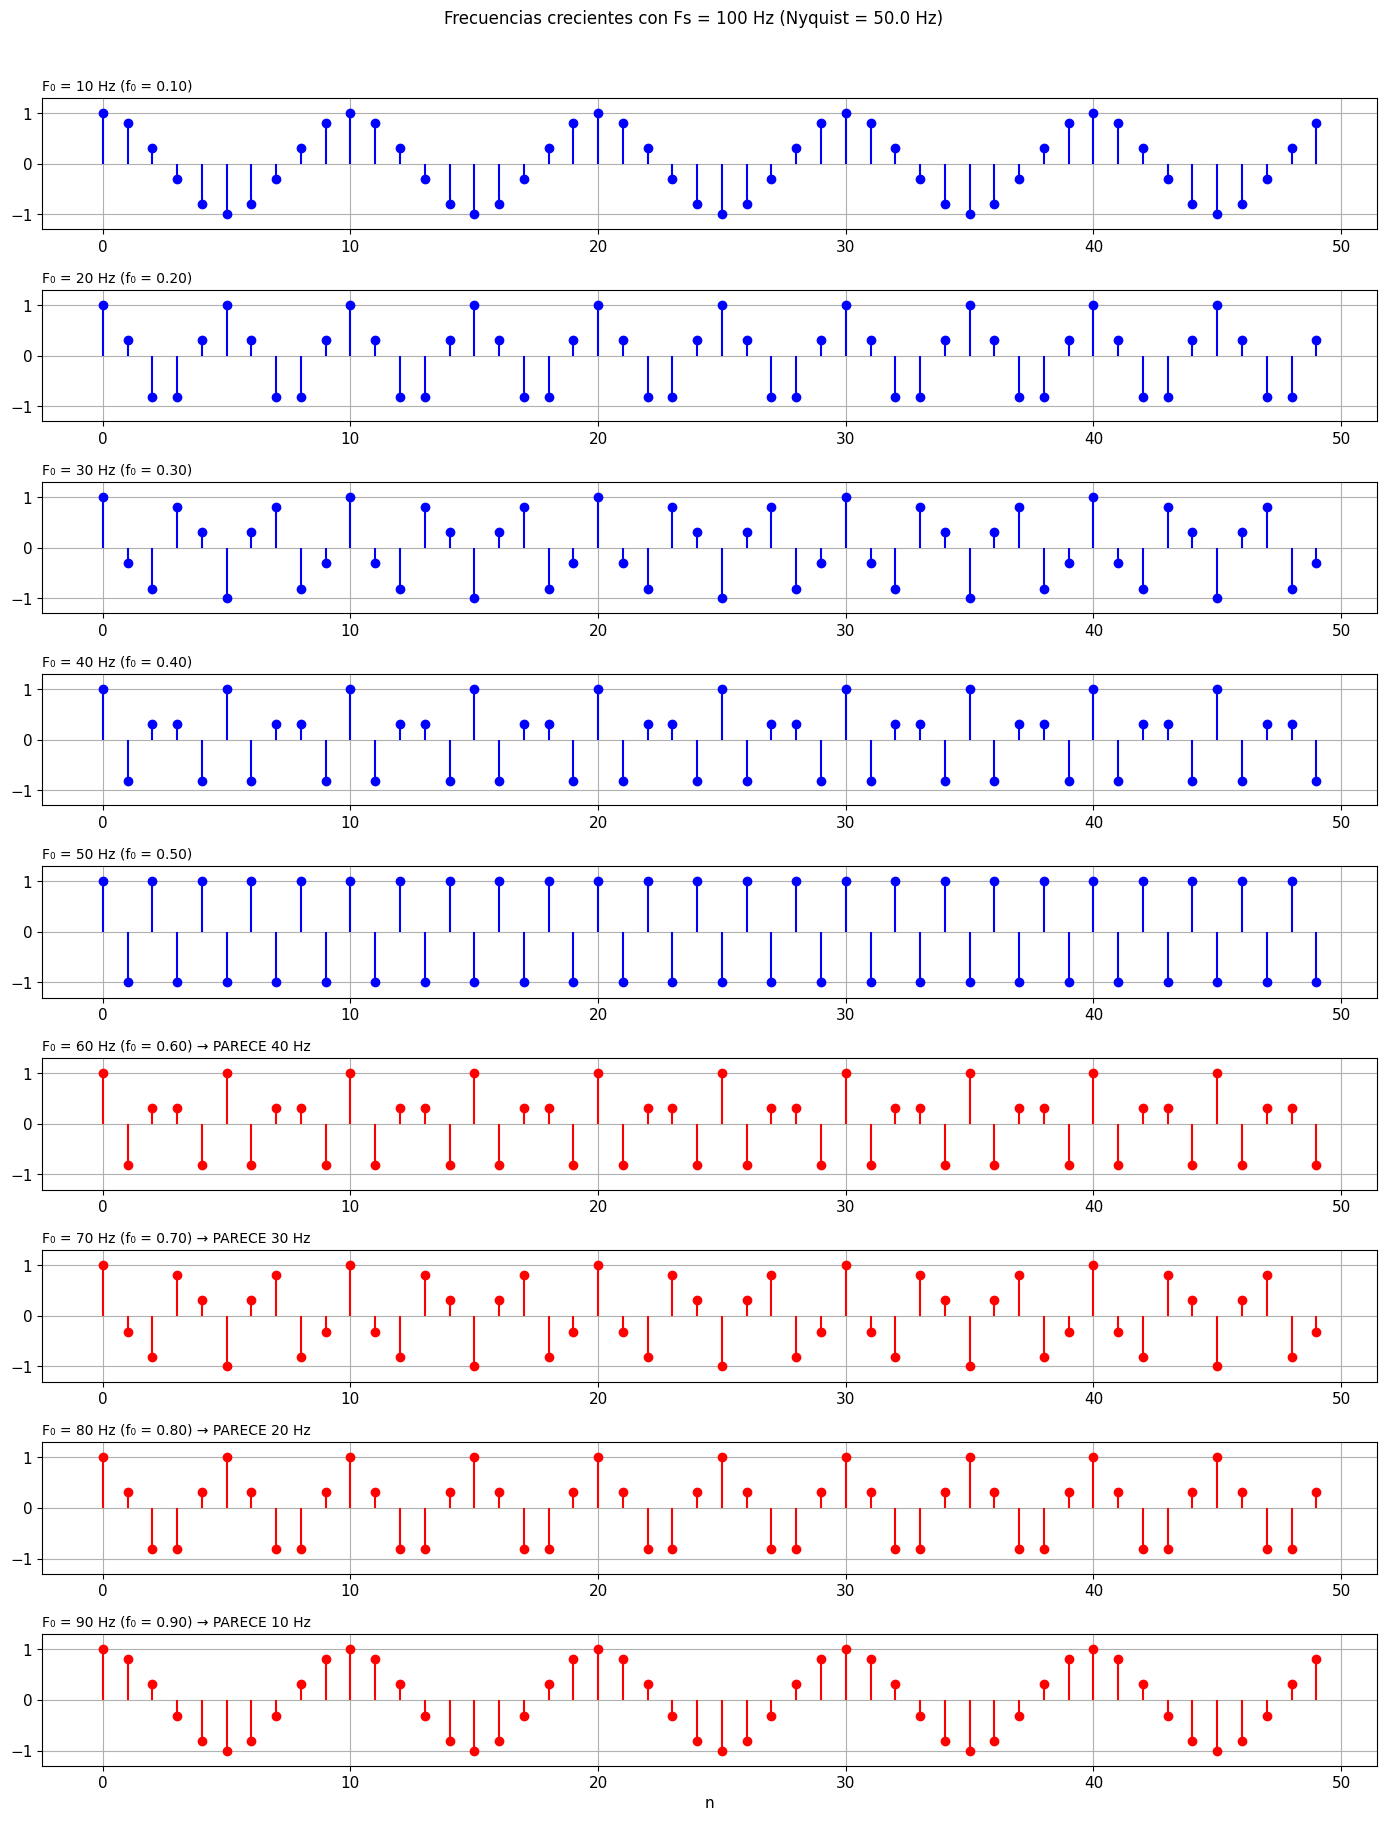

Las señales en ROJO (F₀ > 50.0 Hz) son indistinguibles de señales
con frecuencia más baja. COMPRUÉBALO VISUALMENTE
¡Las frecuencias discretas están acotadas!


In [14]:
# === DEMOSTRACIÓN con frecuencias físicas ===
Fs_demo = 100  # Hz de muestreo

# Señales con frecuencias crecientes, incluyendo mayores que Fs/2
frecuencias_Hz = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_d = np.arange(50)

fig, axes = plt.subplots(len(frecuencias_Hz), 1, figsize=(14, 2*len(frecuencias_Hz)))

for i, F0 in enumerate(frecuencias_Hz):
    x_F0 = np.cos(2 * np.pi * F0 * n_d / Fs_demo)
    f0_norm = F0 / Fs_demo

    # Frecuencia equivalente
    f0_eq = f0_norm
    if f0_eq > 0.5:
        f0_eq = 1.0 - f0_eq
    F0_eq = f0_eq * Fs_demo

    color = 'b' if F0 <= Fs_demo/2 else 'r'
    axes[i].stem(n_d, x_F0, basefmt=' ', markerfmt=f'{color}o', linefmt=f'{color}-')

    nota = ""
    if F0 > Fs_demo/2:
        nota = f" → PARECE {F0_eq:.0f} Hz"
    axes[i].set_title(f'F₀ = {F0} Hz (f₀ = {f0_norm:.2f}){nota}', fontsize=10, loc='left')
    axes[i].set_ylim([-1.3, 1.3])

axes[-1].set_xlabel('n')
plt.suptitle(f'Frecuencias crecientes con Fs = {Fs_demo} Hz (Nyquist = {Fs_demo/2} Hz)', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

print(f"Las señales en ROJO (F₀ > {Fs_demo/2} Hz) son indistinguibles de señales")
print(f"con frecuencia más baja. COMPRUÉBALO VISUALMENTE")
print(f"¡Las frecuencias discretas están acotadas!")

### ✍️ Explicación (OBLIGATORIA)

**1. Observa las gráficas: ¿qué pasa al llegar a $f_0 = 0.5$? ¿Y al superarlo?**

*Tu respuesta:*

```
Lo que ocurre al llegar a $f_0 = 0.5$ es que la señal alcanza su máxima frecuencia representable, y a partir de ese punto, al superar $f_0 = 0.5$, la señal comienza a "oscilar más lento" debido al aliasing, ya que las frecuencias mayores a 0.5 se pliegan de vuelta al rango de -0.5 a 0.5.
```

**2. ¿Por qué $\cos(2\pi \cdot 0.3 \cdot n)$ y $\cos(2\pi \cdot 0.7 \cdot n)$ producen la misma señal discreta?**

*Tu respuesta:*

```
Porque al hacer la transformación de frecuencia, se observa que $0.7$ es equivalente a $0.3 + 1$, y debido a la periodicidad de la función coseno,se tiene que la primera señal se puede expresar como $\cos(2\pi \cdot 0.3 \cdot n)$ y la segunda como $\cos(2\pi \cdot (0.3 + 1) \cdot n)$, lo que demuestra que ambas señales son idénticas en términos de su representación discreta. ```

**3. Conecta este resultado con el límite de Nyquist: ¿por qué necesitamos $F_s > 2F_0$?**

*Tu respuesta:*

```
Lo necesitamos porque si F_s no es mayor que 2F_0, entonces F_0 sería mayor que F_s/2, lo que significa que la frecuencia de la señal estaría por encima del límite de Nyquist, y por lo tanto se produciría aliasing, haciendo que la señal muestreada no represente correctamente la señal original.

```

---

### Bloque 4C: Diezmado — reducción deliberada de muestras

#### Contexto teórico

| Concepto | Definición |
|----------|------------|
| **Muestreo** | Discretizar una señal continua a frecuencia $F_s$ |
| **Diezmado** | Tomar 1 de cada $D$ muestras de una señal **ya discreta** |

El diezmado por factor $D$ reduce el número de muestras de una señal y, por lo tanto, la frecuencia de muestreo efectiva:

$$F_s' = \frac{F_s}{D}$$

**Peligro:** Si $F_s' < 2F$, aparece aliasing.

---

#### 📝 Hipótesis previa

**Pregunta:** Con señal de $F=5$ Hz y $F_s=50$ Hz:

- Con $D=2$: $F_s' = $ 25 Hz. ¿Cumple Nyquist ($F_s' > 2F$)? Si ya que $F_s' = 25$ Hz es mayor que $2F = 10$ Hz, entonces sí cumple Nyquist y no se produce aliasing.
- Con $D=5$: $F_s' = $ 10 Hz. ¿Cumple Nyquist? No porque $F_s' = 10$ Hz no es mayor que $2F = 10$ Hz, por lo tanto se produce aliasing.
- Con $D=10$: $F_s' = $ 5 Hz. ¿Cumple Nyquist? No porque $F_s' = 5$ Hz no es mayor que $2F = 10$ Hz, por lo tanto se produce aliasing.


In [15]:
# === IMPLEMENTACIÓN ===
factores_diezmado = [2, 5, 10]

# TODO: Diezma la señal para cada factor
señales_diezmadas = {}
for D in factores_diezmado:
    # TODO: Diezma la señal para cada factor D, guardando el resultado en x_d
    x_d =x[::D] # toma cada D-ésima muestra
    ###

    # Fs' = Fs / D
    Fs_d = Fs / D
    señales_diezmadas[D] = {
        'señal': x_d,
        'Fs_nueva': Fs_d,
        'cumple_nyquist': Fs_d > 2 * F
    }
    print(f"D={D}: Fs'={Fs_d:.1f} Hz, N'={len(x_d) if x_d is not None else '?'}, ¿Nyquist? {Fs_d > 2*F}")

D=2: Fs'=25.0 Hz, N'=25, ¿Nyquist? True
D=5: Fs'=10.0 Hz, N'=10, ¿Nyquist? False
D=10: Fs'=5.0 Hz, N'=5, ¿Nyquist? False


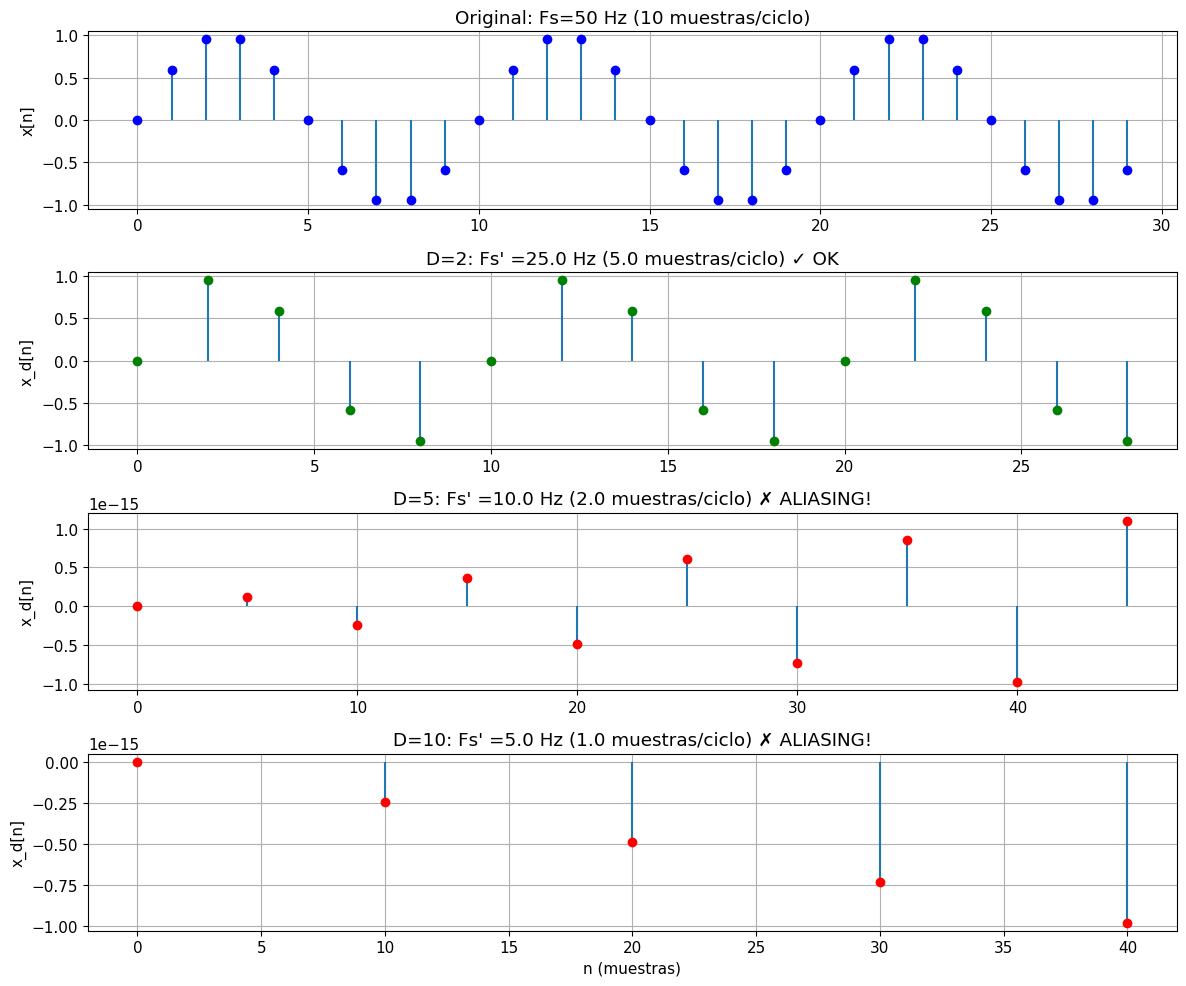

In [16]:
# === VISUALIZACIÓN COMPARATIVA ===
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=False)

# Original
axes[0].stem(n[:30], x[:30], basefmt=' ', markerfmt='bo')
axes[0].set_title(f'Original: Fs={Fs} Hz (10 muestras/ciclo)')
axes[0].set_ylabel('x[n]')

# Diezmados
for i, D in enumerate(factores_diezmado):
    datos = señales_diezmadas[D]
    x_d = x[::D]
    color = 'g' if datos['cumple_nyquist'] else 'r'
    estado = '✓ OK' if datos['cumple_nyquist'] else '✗ ALIASING!'

    muestras_ciclo = datos['Fs_nueva'] / F
    axes[i+1].stem(n[::D][:15], x_d[:15], basefmt=' ', markerfmt=f'{color}o')
    axes[i+1].set_title(f'D={D}: Fs\' ={datos["Fs_nueva"]:.1f} Hz ({muestras_ciclo:.1f} muestras/ciclo) {estado}')
    axes[i+1].set_ylabel('x_d[n]')

axes[-1].set_xlabel('n (muestras)')
plt.tight_layout()
plt.show()

### ✍️ Explicación (OBLIGATORIA)

**1. ¿Qué diferencia hay entre muestrear y diezmar?**

*Tu respuesta:*

```
Muestrear es el proceso de convertir una señal continua en una señal discreta tomando muestras a intervalos regulares, mientras que diezmar es el proceso de reducir la cantidad de muestras de una señal discreta existente, tomando solo una muestra cada D muestras. El muestreo se realiza sobre señales continuas, mientras que el diezmado se realiza sobre señales ya discretas.
```

**2. Con $D=10$. ¿Cuál debería ser la frecuencia de muestreo original $F_s$ para que la señal diezmada no tenga aliasing?**

*Tu respuesta:*

```
La frecuencia de muestreo original F_s debería ser mayor que 2F * D para evitar aliasing después del diezmado. En este caso, F_s > 2 * 5 Hz * 10 = 100 Hz. Por lo tanto, la frecuencia de muestreo original debería ser mayor que 100 Hz para que la señal diezmada no tenga aliasing.
```

---

## Parte 5: Aliasing — violación del criterio de Nyquist

### Contexto teórico

El **aliasing** ocurre cuando una frecuencia $F > F_s/2$ se "disfraza" de una frecuencia más baja:

$$F_{\text{alias}} = |F - k \cdot F_s|$$

donde $k$ es el entero que minimiza el resultado y lo pone en el rango $[0, F_s/2]$.

En la Parte 4 vimos que las frecuencias discretas están acotadas. El aliasing es la **consecuencia práctica** directa: si intentamos representar una frecuencia mayor que $F_s/2$, "se pliega" al rango permitido.

---

### Bloque 5A · Aliasing visual

#### 📝 Hipótesis previa

**Pregunta:** Si $F = 15$ Hz y $F_s = 20$ Hz:

- Frecuencia de Nyquist: $F_s/2 = $ ____ Hz
- ¿Se viola Nyquist ($F > F_s/2$)? ____
- Frecuencia alias esperada: $|15 - 20| = $ ____ Hz

In [21]:
# === IMPLEMENTACIÓN ===
F_real = 15      # Hz (frecuencia real)
Fs_bajo = 20     # Hz (frecuencia de muestreo - viola Nyquist!)
T_demo = 1       # segundo

# Señal con aliasing
N_bajo = int(Fs_bajo * T_demo)
n_bajo = np.arange(N_bajo)
x_alias = np.sin(2 * np.pi * F_real * n_bajo / Fs_bajo)

# Señal de referencia: bien muestreada
Fs_ref = 200     # Hz (mucho mayor que 2*15 = 30 Hz)
N_ref = int(Fs_ref * T_demo)
n_ref = np.arange(N_ref)
x_ref = np.sin(2 * np.pi * F_real * n_ref / Fs_ref)
t_ref = n_ref / Fs_ref

# TODO: Calcula frecuencia alias teórica, F_alias, según la fórmula de arriba para k=1
k = 1
F_alias = abs(F_real - k * Fs_bajo)
print(f"Frecuencia real: F_real = {F_real} Hz") 
print(f"Frecuencia de muestreo: Fs_bajo = {Fs_bajo} Hz") 
print(f"Frecuencia alias teórica: F_alias = |{F_real} - {k}*{Fs_bajo}| = {F_alias} Hz")

Frecuencia real: F_real = 15 Hz
Frecuencia de muestreo: Fs_bajo = 20 Hz
Frecuencia alias teórica: F_alias = |15 - 1*20| = 5 Hz


In [22]:
# === VALIDACIÓN ===
assert F_alias == abs(F_real - Fs_bajo), "No has calculado correctamente la frecuencia alias teórica"

print(f"Frecuencia real: {F_real} Hz")
print(f"Frecuencia de muestreo: {Fs_bajo} Hz")
print(f"Frecuencia de Nyquist: {Fs_bajo/2} Hz")
print(f"¿Viola Nyquist? {F_real > Fs_bajo/2}")
print(f"Frecuencia alias teórica: {F_alias} Hz")

Frecuencia real: 15 Hz
Frecuencia de muestreo: 20 Hz
Frecuencia de Nyquist: 10.0 Hz
¿Viola Nyquist? True
Frecuencia alias teórica: 5 Hz


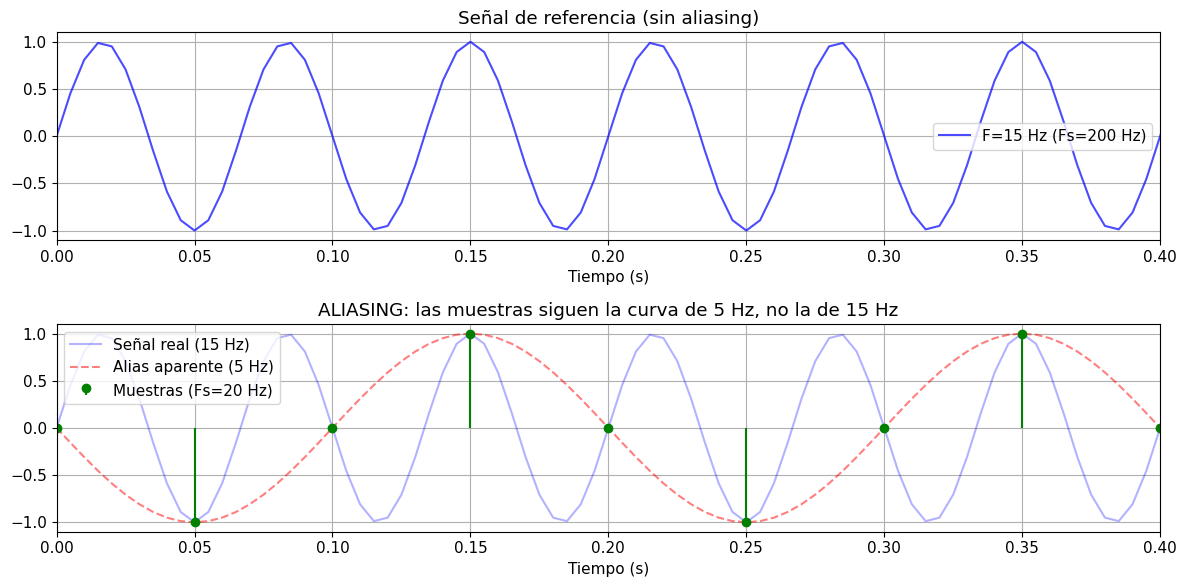

In [23]:
# === VISUALIZACIÓN ===
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Referencia (bien muestreada)
axes[0].plot(t_ref, x_ref, 'b-', alpha=0.7, label=f'F={F_real} Hz (Fs={Fs_ref} Hz)')
axes[0].set_title('Señal de referencia (sin aliasing)')
axes[0].set_xlabel('Tiempo (s)')
axes[0].set_xlim([0, 0.4])
axes[0].legend()

# Con aliasing
t_bajo = n_bajo / Fs_bajo
axes[1].plot(t_ref, x_ref, 'b-', alpha=0.3, label='Señal real (15 Hz)')

x_alias_visual = np.sin(2 * np.pi * F_alias * t_ref + np.pi)
axes[1].plot(t_ref, x_alias_visual, 'r--', alpha=0.5, label=f'Alias aparente ({F_alias} Hz)')

axes[1].stem(t_bajo, x_alias, 'g', markerfmt='go', basefmt=' ',
             label=f'Muestras (Fs={Fs_bajo} Hz)')
axes[1].set_title(f'ALIASING: las muestras siguen la curva de {F_alias} Hz, no la de {F_real} Hz')
axes[1].set_xlabel('Tiempo (s)')
axes[1].set_xlim([0, 0.4])
axes[1].legend()

plt.tight_layout()
plt.show()

---

### Bloque 6B · Aliasing audible — escuchar el fenómeno

El aliasing no es solo un concepto matemático: tiene consecuencias **perceptibles**.

#### 📝 Hipótesis previa

Si generamos un tono de 3000 Hz y lo muestreamos a 5000 Hz:

- Frecuencia de Nyquist: $F_N = 5000/2 = 2500$ Hz
- ¿3000 Hz > 2500 Hz? → Frecuencia alias: $|3000 - 5000| = 2000 Hz


In [ ]:
# === IMPLEMENTACIÓN ===
F_tono = 3000    # Hz
duracion = 1.5   # segundos

# Caso 1: Sin aliasing (Fs alta)
Fs_ok = 8000     # Hz (cumple Nyquist: 8000 > 2*3000)
N_ok = int(Fs_ok * duracion)
n_ok = np.arange(N_ok)
x_ok = 0.5 * np.sin(2 * np.pi * F_tono * n_ok / Fs_ok)

# Caso 2: Con aliasing (Fs baja)
Fs_mal = 5000    # Hz (viola Nyquist: 5000 < 2*3000)
N_mal = int(Fs_mal * duracion)
n_mal = np.arange(N_mal)
x_mal = 0.5 * np.sin(2 * np.pi * F_tono * n_mal / Fs_mal)

# Frecuencia alias
F_alias_audio = abs(F_tono - Fs_mal)

print(f"Tono original: {F_tono} Hz")
print(f"\nCaso 1 (sin aliasing):")
print(f"  Fs = {Fs_ok} Hz, Frecuencia de Nyquist F_N = {Fs_ok/2} Hz → OK")
print(f"\nCaso 2 (con aliasing):")
print(f"  Fs = {Fs_mal} Hz, Frecuencia de Nyquist F_N = {Fs_mal/2} Hz → ALIASING")
print(f"  Frecuencia alias: |{F_tono} - {Fs_mal}| = {F_alias_audio} Hz")

Tono original: 3000 Hz

Caso 1 (sin aliasing):
  Fs = 8000 Hz, Frecuencia de Nyquist F_N = 4000.0 Hz → OK

Caso 2 (con aliasing):
  Fs = 5000 Hz, Frecuencia de Nyquist F_N = 2500.0 Hz → ALIASING
  Frecuencia alias: |3000 - 5000| = 2000 Hz


In [ ]:
# === REPRODUCCIÓN DE AUDIO ===
print("Escucha el tono SIN aliasing (3000 Hz):")
display(Audio(x_ok, rate=Fs_ok))

print(f"\nEscucha el tono CON aliasing (sonará como {F_alias_audio} Hz):")
display(Audio(x_mal, rate=Fs_mal))

# Tono de referencia a la frecuencia alias
Fs_ref_audio = 8000
N_ref_audio = int(Fs_ref_audio * duracion)
n_ref_audio = np.arange(N_ref_audio)
x_ref_alias = 0.5 * np.sin(2 * np.pi * F_alias_audio * n_ref_audio / Fs_ref_audio)

print(f"\nTono de referencia a {F_alias_audio} Hz (para comparar):")
display(Audio(x_ref_alias, rate=Fs_ref_audio))

Escucha el tono SIN aliasing (3000 Hz):


Escucha el tono SIN aliasing (3000 Hz):



Escucha el tono CON aliasing (sonará como 2000 Hz):



Tono de referencia a 2000 Hz (para comparar):


### ✍️ Explicación (OBLIGATORIA)

**1. Observa la gráfica de aliasing: los puntos verdes ¿siguen la curva azul (15 Hz) o la roja (5 Hz)?**

*Tu respuesta:*

```
Siguen la curva roja (5 Hz), lo que indica que la frecuencia de 15 Hz se ha plegado a 5 Hz debido al aliasing, ya que 15 Hz es mayor que la frecuencia de Nyquist de 10 Hz.
```

**2. ¿Suenan igual el segundo y tercer audio? ¿Qué frecuencia percibes en cada uno?**

*Tu respuesta:*

```
Si suenan igual el segundo y tercer audio, es porque ambos tienen la misma frecuencia alias de 2000 Hz. En ambos casos, aunque la frecuencia original es diferente (3000 Hz), debido al aliasing, ambos tonos se perciben como si tuvieran una frecuencia de 2000 Hz.
```

**3. Conecta el aliasing con la Parte 4: ¿por qué el aliasing es una consecuencia directa de que las frecuencias discretas están acotadas?**

*Tu respuesta:*

```
Porque las frecuencias discretas están acotadas al rango de -F_s/2 a F_s/2, cualquier frecuencia que exceda ese límite se pliega de vuelta dentro de ese rango, lo que resulta en el fenómeno de aliasing. Es decir, el aliasing es la manifestación práctica de la limitación en la representación de frecuencias en señales discretas.
```

**4. Si solo tuvieras las muestras (sin saber la señal original), ¿podrías saber que hubo aliasing?**

*Tu respuesta:*

```
No, no podrías saber con certeza que hubo aliasing solo a partir de las muestras, ya que el aliasing hace que diferentes frecuencias originales puedan producir la misma señal muestreada. Sin información adicional sobre la señal original o el proceso de muestreo, no es posible determinar si una frecuencia específica es el resultado de aliasing.
```

---

## 🔍 Checkpoint del profesor

- [ ] Señal periódica correcta con Nyquist cumplido
- [ ] Función de consulta temporal implementada con interpolación
- [ ] Periodicidad verificada: caso racional vs irracional
- [ ] Frecuencias acotadas demostradas visualmente
- [ ] Diezmado implementado y efectos visualizados
- [ ] Aliasing demostrado visual y auditivamente

---

## Preguntas de control

### P1. ¿Qué información necesitas, además de la secuencia $x[n]$, para saber qué valor tiene la señal en un instante $t$ concreto?

*Tu respuesta:*

```
Necesito conocer el periodo de muestreo $T_s$ para convertir el índice de muestra $n$ a tiempo, y también necesito saber el instante inicial $t_{inicio}$ para saber a qué instante de tiempo corresponde la primera muestra (n=0). Con esta información, puedo calcular el índice de muestra correspondiente al instante $t$ y obtener el valor de la señal en ese instante.
```

---

### P2. Explica por qué $\cos(2\pi \cdot 0.3 n)$ y $\cos(2\pi \cdot 0.7 n)$ son la misma señal discreta.

*Tu respuesta:*

```
Porque al hacer la transformación de frecuencia, se observa que $0.7$ es equivalente a $0.3 + 1$, y debido a la periodicidad de la función coseno, se tiene que la primera señal se puede expresar como $\cos(2\pi \cdot 0.3 \cdot n)$ y la segunda como $\cos(2\pi \cdot (0.3 + 1) \cdot n)$, lo que demuestra que ambas señales son idénticas en términos de su representación discreta.
```

---

### P3. Sea $x(t) = \cos(2\pi \cdot 7 t)$ muestreada con $F_s = 40$ Hz. ¿Es periódica la señal discreta? Calcula el periodo $N$.

*Tu respuesta:*

```
No, la señal discreta no es periódica porque la frecuencia normalizada $f_0 = F_0 / F_s = 7 / 40 = 0.175$ no es un número racional. Por lo tanto, no existe un periodo $N$ tal que $f_0 = k/N$ con $k, N \in \mathbb{Z}$, lo que implica que la señal discreta no se repetirá exactamente en ningún punto y no será periódica.
```

---

### P4. Calcula: Si $f = 45$ Hz y $F_s = 80$ Hz, ¿cuál es la frecuencia alias?

*Tu respuesta:*

```
La frecuencia de Nyquist es $F_s/2 = 80/2 = 40$ Hz. Dado que $f = 45$ Hz es mayor que la frecuencia de Nyquist, se produce aliasing. La frecuencia alias se calcula como $|f - F_s| = |45 - 80| = 35$ Hz. Por lo tanto, la frecuencia alias es 35 Hz.
```

---

### P5. ¿Por qué el aliasing es irreversible?

*Tu respuesta:*

```
Porque el aliasing hace que diferentes frecuencias originales puedan producir la misma señal muestreada. Esto significa que, una vez que se ha producido el aliasing, no es posible determinar con certeza cuál era la frecuencia original de la señal, ya que múltiples frecuencias podrían haber dado lugar a la misma señal muestreada. Sin información adicional sobre la señal original o el proceso de muestreo, no es posible revertir el aliasing para recuperar la frecuencia original.
```

---

## ✅ Checklist final

- [ ] Run All sin errores
- [ ] Muestreo correcto implementado (Parte 1)
- [ ] Función de consulta temporal con interpolación (Parte 2)
- [ ] Periodicidad: caso racional vs irracional demostrado (Parte 3)
- [ ] Frecuencias acotadas visualizadas (Parte 4)
- [ ] Diezmado con diferentes factores (Parte 5)
- [ ] Aliasing visualizado en tiempo y escuchado en audio (Parte 6)
- [ ] Todas las explicaciones completadas

---

## 📚 Resumen de conceptos clave

| Concepto | Definición |
|----------|------------|
| **Frecuencia de Nyquist** | $F_N = F_s/2$ |
| **Criterio de Nyquist** | $F_s > 2 f_{\max}$ para evitar aliasing |
| **Consulta temporal** | Necesita $F_s$ y $t_{inicio}$ para traducir $t \to n$ |
| **Frecuencia normalizada** | $F_0 = F_0/F_s$ (ciclos/muestra) |
| **Periodicidad discreta** | Solo si $F_0 = k/N$ es racional |
| **Frecuencias acotadas** | $f_0 \in [-1/2, 1/2)$ — no hay frecuencias infinitas |
| **Muestreo vs Diezmado** | Continua→discreta vs reducir muestras |
| **Aliasing** | Frecuencias altas "se pliegan" al rango $[0, F_s/2]$ |
| **Irreversibilidad** | No se puede recuperar la frecuencia original |

---
